# Primal-dual Newton's method for TV Denoising

We present the Primal-dual Newton's method to solver the Total Variation denoising problem

$$ \min_{m \in \mathcal{M}} J(m) = \min_{m} \int_\Omega (m -d)^2 d{\boldsymbol{x}} + \alpha \int_\Omega |\nabla m |_\beta d{\boldsymbol{x}}, $$

where $d = d({\boldsymbol{x}})$ is the data (noisy image), $\alpha > 0$ is the regularization parameter, and $|\nabla m|_\beta = \sqrt{\|\nabla m^2\| + \beta}$ with $\beta > 0$ leads to a differentiable approximation of the TV functional.

The variational formulation of the first order optimality conditions reads

*Find $m \in \mathcal{M}$ such that:* 

$$ \int_\Omega ( m - d)\tilde{m} d{\boldsymbol{x}} + \alpha \int_\Omega \frac{\nabla m \cdot \nabla\tilde{m}}{|\nabla m|_\beta} d{\boldsymbol{x}} = 0 \quad \forall \tilde{m} \in \mathcal{M}. $$

By standard techniques, we can show that if $m$ is smooth enough the above variational form is equivalent to solving the boundary value problem

$$
\left\{
\begin{array}{ll}
-\alpha \nabla \cdot \left( \frac{\nabla m}{| \nabla m |_\beta} \right) + m = d, & \text{in } \Omega\\
\alpha \left( \frac{\nabla m}{| \nabla m |_\beta} \right) \cdot {\boldsymbol n} = 0, & \text{on } \partial\Omega,
\end{array}
\right.
$$
where ${\boldsymbol n}$ is the unit outward normal vector to $\partial\Omega$.

A key observation is that the nonlinearity in the term
$$ \boldsymbol{w} = \frac{\nabla m}{| \nabla m |_\beta} $$
is the cause of the slow convergence of the Newton's method, althought the variable $\boldsymbol{w}$ itself is usually smooth since it represents the unit normal vector to the level sets of $m$.

The primal-dual Newton's method then explicitly introduce the variable $\boldsymbol{w}$ in the first optimality conditions leading to the system of equations

$$
\left\{
\begin{array}{ll}
-\alpha \nabla \cdot \boldsymbol{w} + m = d, & \text{in } \Omega\\
\boldsymbol{w}|\nabla m|_\beta - \nabla m = 0, & \text{in } \Omega,\\
\end{array}
\right.
$$
equipped with the boundary conditions $\nabla m \cdot \boldsymbol{n} = \boldsymbol{w} \cdot \boldsymbol{n} = 0$ on $\partial \Omega$.

In the primal-dual method, the Newton direction $(\hat{m}_k, \boldsymbol{\hat{w}}_k)$ is obtained by linearizing the system of nonlinear equation around a point $(m_k, \boldsymbol{w}_k)$ and solving

$$
\begin{bmatrix}
- \alpha \nabla \cdot & I \\
| \nabla m_k |_\beta & -\left( I - \frac{\boldsymbol{w_k}\otimes \nabla m_k}{| \nabla m_k |_\beta}\right) \nabla \\
\end{bmatrix}
\begin{bmatrix} \boldsymbol{\hat{w}}_k \\ \hat{m}_k \end{bmatrix} = 
- \begin{bmatrix} 
-\alpha \nabla \cdot \boldsymbol{w}_k + m_k - d \\
\boldsymbol{w_k}|\nabla m_k|_\beta - \nabla m_k
\end{bmatrix}
$$

The solution is then updated as

$$
m_{k+1} = m_{k} + \alpha_m \hat{m}_k, \quad \boldsymbol{w}_{k+1} = \boldsymbol{w}_k +\alpha_w \boldsymbol{\hat{w}}_k,
$$ 

where $\alpha_m$ is chosen to ensure sufficient descent of $J(m)$ and $\alpha_w$ is chosen to ensure $\boldsymbol{w}_{k+1} \cdot \boldsymbol{w}_{k+1} \leq 1$.




## 1. Python imports

We import the following libraries:

- `math`, which contains several mathematical functions
- `matplotlib, numpy, scipy`, three libraries that together allow similar functionalities to matlab
- `dolfin`, which allows us to discretize and solve variational problems using the finite element method
- `hippylib`, the extesible framework I created to solve inverse problems in Python

Finally, we import the `logging` library to silence most of the output produced by `dolfin`.

In [1]:
import math

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy.io as sio

import dolfin as dl

import hippylib as hp
from hippylib import nb

import logging

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

## 2. Geometry, true image, and data.

1. Read the true image from file, store the pixel values in `data`

2. The width of the image is `Lx = 1` and height `Ly` is set such that the aspect ratio of the image is preserved.

3. Generate a triangulation (pixelation) `mesh` of the region of interest.

4. Define the finite element spaces: 
   - `Vm` of piecewise linear function on the elements of `mesh` representing the space of discretized images;
   - `Vw` of piecewise constant vector functions on the elements of `mesh` representing the space of the normalized gradients $\boldsymbol{w}$
   - `Vwnom` of piecewise constant functions on the elements of `mesh` representing the space of the $l^2$ of the normalized gradients $\boldsymbol{w}$

5. Interpolate the true image in the discrete space `Vm`. Call this interpolation `m_true`.

6. Corrupt the true image with i.i.d. Gaussian noise ($\sigma^2 = 0.09$) and interpolated the noisy image in the discrete space `Vm`. Call this interpolation `d`.

7. Visualize the true image `m_true` and the noisy image `d`.

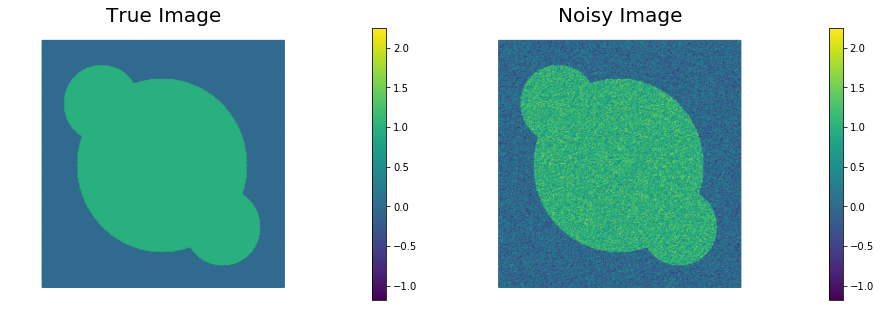

In [2]:
data = sio.loadmat('circles.mat')['im']

Lx = 1.
h = Lx/float(data.shape[0])
Ly = float(data.shape[1])*h
  
mesh = dl.RectangleMesh(dl.Point(0,0),dl.Point(Lx,Ly),data.shape[1], data.shape[0])
Vm = dl.FunctionSpace(mesh, "Lagrange",1)
Vw = dl.VectorFunctionSpace(mesh, "DG", 0)
Vwnorm = dl.FunctionSpace(mesh, "DG",0)

trueImage = hp.NumpyScalarExpression2D()
trueImage.setData(data, h, h)
m_true  = dl.interpolate(trueImage, Vm)

np.random.seed(seed=1)
noise_std_dev = .3
noise = noise_std_dev*np.random.randn(data.shape[0], data.shape[1])
noisyImage = hp.NumpyScalarExpression2D()
noisyImage.setData(data+noise, h, h)
d = dl.interpolate(noisyImage, Vm)

# Get min/max of noisy image, so that we can show all plots in the same scale
vmin = np.min(d.vector().get_local())
vmax = np.max(d.vector().get_local())

plt.figure(figsize=(15,5))
nb.plot(m_true, subplot_loc=121, mytitle="True Image", vmin=vmin, vmax = vmax)
nb.plot(d, subplot_loc=122, mytitle="Noisy Image", vmin=vmin, vmax = vmax)
plt.show()

## 3. Total Variation denoising

The class `PDTVDenosing` defines the cost functional and its first & second variations for the primal dual formulation of the Total Variation denoising problem.

Specifically, the method `cost` implements the cost functional
$$ \mathcal{J}(m) = \frac{1}{2}\int_\Omega (m - d)^2 \; d\boldsymbol{x} + \frac{\alpha}{2}\int_\Omega | \nabla m |_\beta d\boldsymbol{x}, $$
where $\alpha$ is the amount of regularization and $\beta$ is a small pertubation to ensure differentiability of the total variation functional.

The method `grad_m` implements the first variation of $\mathcal{J}$ w.r.t. $m$
$$ \delta_m \mathcal{J}(m, \tilde{m}) = \int_\Omega (m - m_0)\tilde{m}  \; d\boldsymbol{x} + \alpha \int_\Omega \frac{1}{| \nabla m |_\beta}\nabla m \cdot \nabla \tilde{m}  d\boldsymbol{x}. $$

The method `Hessian` implements the action of primal-dual second variation of $\mathcal{J}$ w.r.t. $m$ in the direction $\hat{m}$:
$$ \int_\Omega \tilde{m} \hat{m} \; d\boldsymbol{x} + \alpha \int_\Omega \frac{1}{| \nabla m |_\beta} \left[ \left( I - A(m,w)\right) \nabla \tilde{m}\right] \cdot \nabla \hat{m} d\boldsymbol{x}, $$

where 

$$ A(m,w) = \frac{1}{2} \boldsymbol{w} \otimes \frac{\nabla m}{|\nabla m|_\beta} + \frac{1}{2} \frac{\nabla m}{|\nabla m|_\beta}\otimes \boldsymbol{w}. $$

Finaly, the method `compute_w_hat` computes the primal dual Newton update for $\boldsymbol{w}$,

$$ \hat{\boldsymbol{w}} = \frac{1}{|\nabla m|_\beta}\left(I - A(m,w) \right)\nabla \hat{m} - \boldsymbol{w} + \frac{\nabla m}{|\nabla m|_\beta}. $$

In [3]:
class PDTVDenoising:
    def __init__(self, Vm, Vw, Vwnorm, d, alpha, beta):
        self.alpha   = dl.Constant(alpha)
        self.beta    = dl.Constant(beta)
        self.d       = d
        self.m_tilde  = dl.TestFunction(Vm)
        self.m_hat = dl.TrialFunction(Vm)
        
        self.Vm = Vm
        self.Vw = Vw
        self.Vwnorm = Vwnorm
        
    def cost_reg(self, m):
        return dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)*dl.dx
    
    def cost_misfit(self, m):
        return dl.Constant(.5)*dl.inner(m-self.d, m - self.d)*dl.dx
        
    def cost(self, m):        
        return self.cost_misfit(m) + self.alpha*self.cost_reg(m)
        
    def grad_m(self, m):    
        grad_ls = dl.inner(self.m_tilde, m - self.d)*dl.dx        
        TVm = dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)
        grad_tv = dl.Constant(1.)/TVm*dl.inner(dl.grad(m), dl.grad(self.m_tilde))*dl.dx
        
        grad = grad_ls + self.alpha*grad_tv
        
        return grad
        
    def Hessian(self,m, w):
        H_ls = dl.inner(self.m_tilde, self.m_hat)*dl.dx
        
        TVm = dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)
        A = dl.Constant(1.)/TVm * (dl.Identity(2) 
                                   - dl.Constant(.5)*dl.outer(w, dl.grad(m)/TVm )
                                   - dl.Constant(.5)*dl.outer(dl.grad(m)/TVm, w ) )
        
        H_tv = dl.inner(A*dl.grad(self.m_tilde), dl.grad(self.m_hat))*dl.dx
         
        H = H_ls + self.alpha*H_tv
                                   
        return H
    
    def compute_w_hat(self, m, w, m_hat):
        TVm = dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)
        A = dl.Constant(1.)/TVm * (dl.Identity(2) 
                                   - dl.Constant(.5)*dl.outer(w, dl.grad(m)/TVm )
                                   - dl.Constant(.5)*dl.outer(dl.grad(m)/TVm, w ) )
        
        expression = A*dl.grad(m_hat) - w + dl.grad(m)/TVm
        
        return dl.project(expression, self.Vw)
    
    def wnorm(self, w):
        return dl.inner(w,w)

## 4. Primal dual solution of Total Variation regularized denoising problem

The `PDNewton` function computes the primal dual solution of the total variation regularized denoising problem using the inexact Newton conjugate gradient algorithm with:

- Eisenstat-Walker conditions to reduce the number of conjugate gradient iterations necessary to compute the Newton'direction $\hat{m}$.

- Backtracking linesearch on $m_{k+1}$ based on Armijo's sufficient descent condition

- Backtracking linesearch on $\boldsymbol{w}_{k+1}$ to ensure $\boldsymbol{w}_{k+1} \cdot \boldsymbol{w}_{k+1} \leq 1$.

In [4]:
def PDNewton(pdProblem, m, w, parameters):
    
    termination_reasons = [
                           "Maximum number of Iteration reached",      #0
                           "Norm of the gradient less than tolerance", #1
                           "Maximum number of backtracking reached",   #2
                           "Norm of (g, m_hat) less than tolerance"       #3
                           ]
    
    rtol          = parameters["rel_tolerance"]
    atol          = parameters["abs_tolerance"]
    gdm_tol       = parameters["gdm_tolerance"]
    max_iter      = parameters["max_iter"]
    c_armijo      = parameters["c_armijo"] 
    max_backtrack = parameters["max_backtracking_iter"]
    prt_level     = parameters["print_level"]
    cg_coarse_tol = parameters["cg_coarse_tolerance"]
        
    Jn = dl.assemble( pdProblem.cost(m)   )
    gn = dl.assemble( pdProblem.grad_m(m) )
    g0_norm = gn.norm("l2")
    gn_norm = g0_norm
    tol = max(g0_norm*rtol, atol)
    
    m_hat = dl.Function(pdProblem.Vm)
    w_hat = dl.Function(pdProblem.Vw)
        
    converged = False
    reason = 0
    total_cg_iter = 0
        
    if prt_level > 0:
        print( "{0:>3} {1:>15} {2:>15} {3:>15} {4:>15} {5:>15} {6:>7}".format(
                "It", "cost", "||g||", "(g,m_hat)", "alpha_m", "tol_cg", "cg_it") )
        
    for it in range(max_iter):
        
        # Compute m_hat
        Hn = dl.assemble( pdProblem.Hessian(m,w) )
        solver = dl.PETScKrylovSolver("cg", "petsc_amg")
        solver.set_operator(Hn)
        solver.parameters["nonzero_initial_guess"] = False
        cg_tol = min(cg_coarse_tol, math.sqrt( gn_norm/g0_norm) )
        solver.parameters["relative_tolerance"] = cg_tol
        lin_it = solver.solve(m_hat.vector(),-gn)   
        total_cg_iter += lin_it
        
        # Compute w_hat
        w_hat = pdProblem.compute_w_hat(m, w, m_hat)
            
        ### Line search for m
        mhat_gn = m_hat.vector().inner(gn)
            
        if(-mhat_gn < gdm_tol):
            self.converged=True
            self.reason = 3
            break
        
        alpha_m = 1.   
        bk_converged = False 
        for j in range(max_backtrack):
            Jnext = dl.assemble( pdProblem.cost(m + dl.Constant(alpha_m)*m_hat) )
            if Jnext < Jn + alpha_m*c_armijo*mhat_gn:
                Jn = Jnext
                bk_converged = True
                break
                
            alpha_m = alpha_m/2.
                
        if not bk_converged:
            self.reason = 2
            break
            
        ### Line search for w
        alpha_w = 1
        bk_converged = False
        for j in range(max_backtrack):
            norm_w = dl.project(pdProblem.wnorm(w + dl.Constant(alpha_w)*w_hat), pdProblem.Vwnorm)
            if norm_w.vector().norm("linf") <= 1:
                bk_converged = True
                break
            alpha_w = alpha_w/2.
        
        
        ### Update
        m.vector().axpy(alpha_m, m_hat.vector())
        w.vector().axpy(alpha_w, w_hat.vector())
        
        gn = dl.assemble( pdProblem.grad_m(m) )
        gn_norm = gn.norm("l2")
            
        if prt_level > 0:
            print( "{0:3d} {1:15e} {2:15e} {3:15e} {4:15e} {5:15e} {6:7d}".format(
                    it, Jn, gn_norm, mhat_gn, alpha_m, cg_tol, lin_it) )
                
        if gn_norm < tol:
            converged = True
            reason = 1
            break
            
    final_grad_norm = gn_norm
        
    if prt_level > -1:
        print( termination_reasons[reason] )
        if converged:
            print( "Inexact Newton CG converged in ", it, \
                "nonlinear iterations and ", total_cg_iter, "linear iterations." )
        else:
            print( "Inexact Newton CG did NOT converge after ", self.it, \
                "nonlinear iterations and ", total_cg_iter, "linear iterations.")
        print ("Final norm of the gradient", final_grad_norm)
        print ("Value of the cost functional", Jn)
            
    return m, w

## 5. Results

The primal dual Newton's methods converges in only 23 iterations compared to the hundreds of iterations we observed in the previous notebook by solving the primal formulation with Newton's method.

 It            cost           ||g||       (g,m_hat)         alpha_m          tol_cg   cg_it
  0    1.291009e-01    1.886530e-03   -2.502929e-01    1.000000e+00    5.000000e-01       1
  1    3.873716e-02    8.860229e-04   -1.582825e-01    1.000000e+00    5.000000e-01       1
  2    2.658464e-02    7.936144e-04   -2.249286e-02    1.000000e+00    5.000000e-01       1
  3    2.550606e-02    5.664402e-04   -1.809066e-03    1.000000e+00    5.000000e-01       1
  4    2.524188e-02    4.059965e-04   -3.389324e-04    1.000000e+00    4.535858e-01       1
  5    2.517445e-02    3.062689e-04   -7.888608e-05    1.000000e+00    3.840109e-01       1
  6    2.514686e-02    2.363270e-04   -3.121976e-05    1.000000e+00    3.335292e-01       1
  7    2.513036e-02    2.331888e-04   -1.890917e-05    1.000000e+00    2.929808e-01       2
  8    2.511869e-02    1.726600e-04   -1.352313e-05    1.000000e+00    2.910290e-01       3
  9    2.511195e-02    1.347310e-04   -7.896096e-06    1.000000e+00    2.504253e

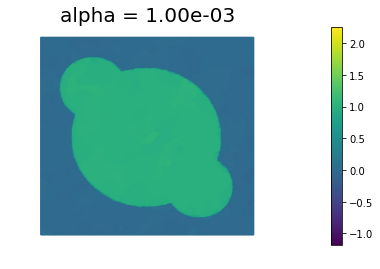

In [5]:
alpha = 1e-3
beta  = 1e-4
pdProblem = PDTVDenoising(Vm, Vw, Vwnorm, d, alpha, beta)

parameters = {}
parameters["rel_tolerance"]         = 1e-6
parameters["abs_tolerance"]         = 1e-9
parameters["gdm_tolerance"]         = 1e-18
parameters["max_iter"]              = 100
parameters["c_armijo"]              = 1e-5
parameters["max_backtracking_iter"] = 10
parameters["print_level"]           = 1
parameters["cg_coarse_tolerance"]   = 0.5

m0 = dl.Function(Vm)
w0 = dl.Function(Vw)

m, w = PDNewton(pdProblem, m0, w0, parameters)

plt.figure()
nb.plot(m, vmin=vmin, vmax = vmax, mytitle="alpha = {0:1.2e}".format(alpha))
plt.show()


---

Copyright &copy; 2019-2020, Washington University in St. Louis.

All Rights reserved.
See file COPYRIGHT for details.

This file is part of **cmis_labs**, the teaching material for  ESE 5932 *Computational Methods for Imaging Science* at Washington University in St. Louis. Please see [https://uvilla.github.io/cmis_labs](https://uvilla.github.io/cmis_labs) for more information and source code availability.

We would like to acknowledge the Extreme Science and Engineering Discovery Environment (XSEDE), which is supported by National Science Foundation grant number ACI-1548562, for providing cloud computing resources (Jetstream) for this course through allocation TG-SEE190001.